In [1]:
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

import astropy.units as u
from astropy.utils.data import download_file
from astropy.utils.data import get_pkg_data_filename
from astropy.io import fits  #  use fits to open the actual data file
from astropy.coordinates import angular_separation
from astropy.utils import data
data.conf.remote_timeout = 60

from tqdm import tqdm
from astropy import wcs
from astropy.wcs import WCS
from astropy.coordinates import FK5
import astropy.units as u
from astropy.coordinates import SkyCoord
from reproject import reproject_interp
from fractions import Fraction
from matplotlib.ticker import MultipleLocator, FuncFormatter
import sys
from scipy.stats import linregress

def piformat(x,pos):
    frac = Fraction(x/np.pi)
    if frac.denominator == 1:
        if frac.numerator == 0:
            return '$0$'
        if frac.numerator == 1:
            return '$\pi$'
        if frac.numerator == -1:
            return '$-\pi$'
        return '$' + '{:g}'.format(frac.numerator) + '\pi$'
    if frac.numerator == 1:
        return '$\pi / ' + '{:g}'.format(frac.denominator) + '$'
    if frac.numerator == -1:
        return '$-\pi / ' + '{:g}'.format(frac.denominator) + '$'
    return '$' + '{:g}'.format(frac.numerator) + '\pi / ' + '{:g}'.format(frac.denominator) + '$'

In [2]:

# This is bringing in the CHIME data
fileQ ='/srv/data/chime/chime_QU_Sep2023/Q_600_800_Sept2023_new_gal_fix.fits'
fileU ='/srv/data/chime/chime_QU_Sep2023/U_600_800_Sept2023_new_gal_fix.fits'
qbe = fits.getdata(fileQ) # qbe and ube (Chime Q and Chime U files) are multiplied by -1 because the
ube = fits.getdata(fileU) # data is incorrect initially
qhdr = fits.getheader(fileQ)
qhdu = fits.open(fileQ)[0]
uhdr = fits.getheader(fileU)
uhdu = fits.open(fileU)[0]
uwcs = WCS(uhdu.header) # World co-ordinates from CHIME
qwcs = WCS(qhdu.header)

In [3]:
# Below is the tedious process of getting the Q and U data for each of the 5 Dwingeloo frequencies
file_Q_408 ='/srv/nmohamme/FITS_cube_tutorial/sp_408_Q_120_cyl.fits';file_U_408 ='/srv/nmohamme/FITS_cube_tutorial/sp_408_U_120_cyl.fits'
file_Q_465 ='/srv/nmohamme/FITS_cube_tutorial/sp_465_Q_120_cyl.fits';file_U_465 ='/srv/nmohamme/FITS_cube_tutorial/sp_465_U_120_cyl.fits';
file_Q_610 ='/srv/nmohamme/FITS_cube_tutorial/sp_610_Q_120_cyl.fits';file_U_610 ='/srv/nmohamme/FITS_cube_tutorial/sp_610_U_120_cyl.fits'
file_Q_820 ='/srv/nmohamme/FITS_cube_tutorial/sp_820_Q_120_cyl.fits';file_U_820 ='/srv/nmohamme/FITS_cube_tutorial/sp_820_U_120_cyl.fits'
file_Q_1411='/srv/nmohamme/FITS_cube_tutorial/sp_1411_Q_120_cyl.fits';file_U_1411='/srv/nmohamme/FITS_cube_tutorial/sp_1411_U_120_cyl.fits'

Q_408 = fits.getdata(file_Q_408);U_408 = fits.getdata(file_U_408)
Q_465 = fits.getdata(file_Q_465);U_465 = fits.getdata(file_U_465)
Q_610 = fits.getdata(file_Q_610);U_610 = fits.getdata(file_U_610)
Q_820 = fits.getdata(file_Q_820);U_820 = fits.getdata(file_U_820)
Q_1411 = fits.getdata(file_Q_1411);U_1411 = fits.getdata(file_U_1411)

Q_610_hdu = fits.open(file_Q_610)[0]
Q_408_hdr = fits.getheader(file_Q_408)
Q_408_hdu = fits.open(file_Q_408)[0]
dwcs = WCS(Q_408_hdu.header) #Dwingeloo WCS
# Dwingeloo_Q and Dwingeloo_U are data cubes of shape (5, 720, 1440) (Frequency, Galactic Latitude, Galactic Longitude). These are INTERPOLATED Data
Dwingeloo_Q = np.array([Q_408, Q_465, Q_610, Q_820, Q_1411])
Dwingeloo_U = np.array([U_408, U_465, U_610, U_820, U_1411])


## re_chimeQ and re_chimeU are the reprojected qbe and ube cubes to the Dwingeloo 720x1440 grid. re_chimeQ and re_chimeU are used for plotting the Dwingelo OG scatter
re_chimeQ, footprint = reproject_interp((qbe[qwcs.wcs_world2pix(1, 1, 614e6, 1)[2].astype(int)], qwcs.celestial), Q_610_hdu.header)
re_chimeU, footprint = reproject_interp((ube[qwcs.wcs_world2pix(1, 1, 614e6, 1)[2].astype(int)], uwcs.celestial), Q_610_hdu.header)


## Below is the process of reading the out files for the Dwingeloo OG data.
l_list = []
b_list = []
ra_list = []
dec_list = []
PI_list = []
gal_theta_list = []
eq_theta_list = []

with open('/srv/data/dwingeloo_data/original/out610') as f:
    for line in f:
        line = f.readline()
        l_list.append(float(line[0:7]))
        b_list.append(float(line[7:13]))
        ra_list.append(float(line[13:19]))
        dec_list.append(float(line[19:25]))
        PI_list.append(float(line[25:31]))
        gal_theta_list.append(float(line[31:37]))
        eq_theta_list.append(float(line[37:43]))
    
f.close()


l_arr = np.asarray(l_list)*u.deg
b_arr = np.asarray(b_list)*u.deg
b_arr[b_arr > 180*u.deg] -= 360*u.deg

ra_arr = np.asarray(ra_list)
dec_arr = np.asarray(dec_list)


dec_arr2 = dec_arr.copy()
dec_arr2[np.where(dec_arr>=270.)] = dec_arr2[np.where(dec_arr>=270.)]-360.
dwinge_q = np.asarray(PI_list)*np.cos(2*np.asarray(gal_theta_list)*np.pi/180.)
dwinge_u = np.asarray(PI_list)*np.sin(2*np.asarray(gal_theta_list)*np.pi/180.)

a floating-point value was expected. [astropy.wcs.wcs]
a floating-point value was expected. [astropy.wcs.wcs]
a floating-point value was expected. [astropy.wcs.wcs]


In [4]:
#pixels in CHIME WCS where dwingeloo beams are
l_pix = qwcs.wcs_world2pix(l_arr, b_arr, 1, 1)[0]
b_pix = qwcs.wcs_world2pix(l_arr, b_arr, 1, 1)[1]

In [5]:
## This cell is important. angular_separation returns, in radians, the separation between two points. For Comparing with the
## DW OG points, instead of comparing the exact CHIME point at the same spot, we are averaging the Stokes Q and Stokes U
## values withing what the CHIME beam would be at whichever frequency we're looking at. 

## idx and array of the index of which CHIME points fall within the beam width, and for each DW OG point we average them.
## A helpful result of the way I've done it here is that chime_q_avg is a 1d array and has the same length of dwinge_q. 
## When we go to create the scatter plot, plotting chiƒme_q_avg right against dwinge_q works out. No need for messing with projections

c = SkyCoord.from_pixel(np.arange(qbe[0].shape[1])[:,np.newaxis], np.arange(qbe[0].shape[0])[np.newaxis,:], qwcs.celestial)
lamb = 3e8/qwcs.wcs_pix2world(1, 1, 475, 1)[2]
radius = (1.22*lamb/25)/2 * u.radian
chime_q_avg = []
chime_u_avg = []
for i in tqdm(np.arange(len(l_arr))):
    sep = angular_separation(np.radians(l_arr[i]), np.radians(b_arr[i]), c.galactic.l, c.galactic.b)
    idx = np.where(sep <= radius)
    chime_q_avg.append(np.nanmean(qbe[475][idx[1], idx[0]]))
    chime_u_avg.append(np.nanmean(ube[475][idx[1], idx[0]]))  

  0%|          | 0/1400 [00:00<?, ?it/s]<ipython-input-5-5fdf4f0bc0c3>:17: RuntimeWarning: Mean of empty slice
  chime_q_avg.append(np.nanmean(qbe[475][idx[1], idx[0]]))
<ipython-input-5-5fdf4f0bc0c3>:18: RuntimeWarning: Mean of empty slice
  chime_u_avg.append(np.nanmean(ube[475][idx[1], idx[0]]))
100%|██████████| 1400/1400 [08:51<00:00,  2.63it/s]


In [6]:
## This cell is a bit of a mess. It creates arrays from chime_q_avg and dwinge_q that are of the FAN region
## Its helpful to look at only the FAN region because its been studied extensively and tends to be high in
## Polarized Intensity, so the signal to noise ratio is better

fan_idx = np.where((b_arr/u.deg > -2) & (b_arr/u.deg < 30) & (l_arr/u.deg > 120) & (l_arr/u.deg < 180)) #fan region index

b_fan = b_arr.copy()
b_fan = b_fan[fan_idx]
l_fan = l_arr.copy()
l_fan = l_fan[fan_idx]

chime_q_avg_fan = np.asarray(chime_q_avg.copy())
chime_q_avg_fan = chime_q_avg_fan[fan_idx]
dwinge_q_fan = np.asarray(dwinge_q.copy())
dwinge_q_fan = dwinge_q_fan[fan_idx]

chime_u_avg_fan = np.asarray(chime_u_avg.copy())
chime_u_avg_fan = chime_u_avg_fan[fan_idx]
dwinge_u_fan = np.asarray(dwinge_u.copy())
dwinge_u_fan = dwinge_u_fan[fan_idx]




chime_theta_avg_fan = 0.5*np.arctan2(chime_u_avg_fan, chime_q_avg_fan)
dwing_theta_fan = 0.5*np.arctan2(dwinge_u_fan, dwinge_q_fan)


PI = (chime_q_avg_fan**2 + chime_u_avg_fan**2)**(0.5)
p = 0.5 # Polarized Intensity cutoff

In [7]:
# Create a boolean mask for the desired points
mask = (chime_theta_avg_fan[:] < -np.pi/4 ) & (dwing_theta_fan > np.pi/4)

# Subtract pi from the corresponding elements
dwing_theta_fan[mask] -= np.pi

mask = (chime_theta_avg_fan[:] > np.pi/4 ) & (dwing_theta_fan < 0)
dwing_theta_fan[mask] += np.pi

1.6134773749028515 0.06991035809430975
1.6147904267841373 0.05070223537674907


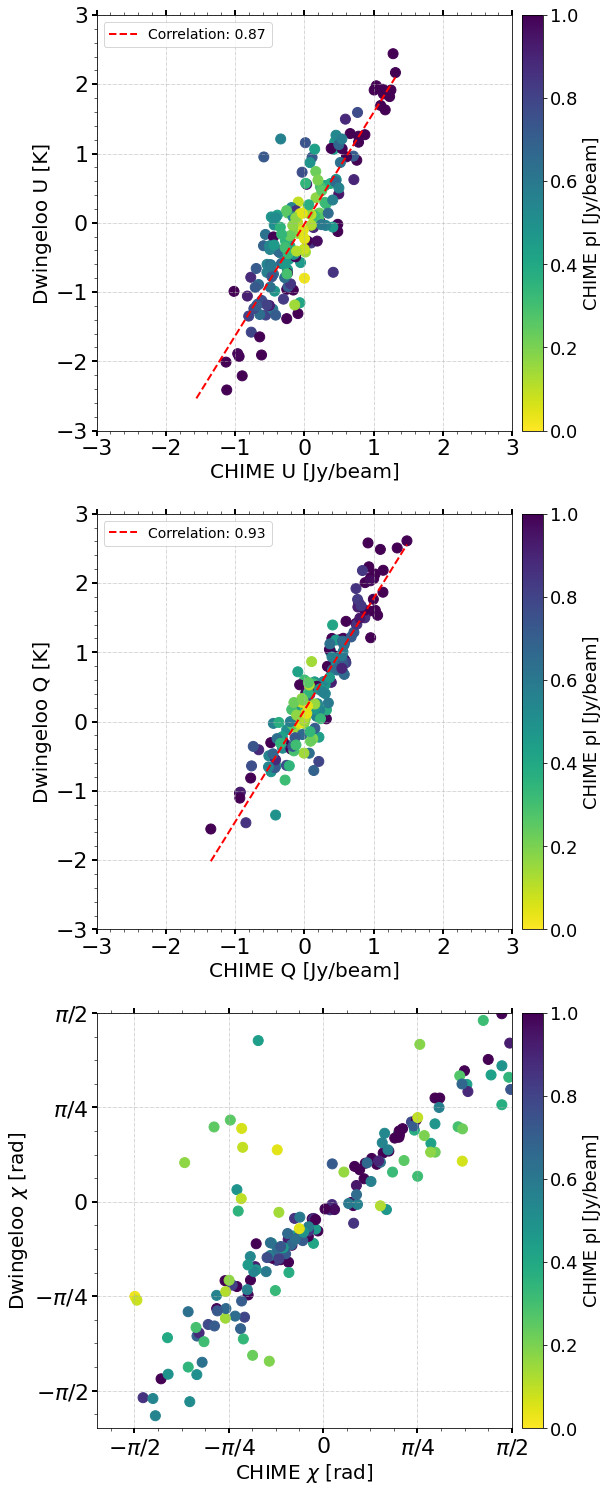

In [9]:
valid_indices_q = np.logical_and(~np.isnan(chime_q_avg_fan), ~np.isnan(dwinge_q_fan))
valid_indices_u = np.logical_and(~np.isnan(chime_u_avg_fan), ~np.isnan(dwinge_u_fan))

# Apply the valid indices to both 'q' and 'u' arrays
chime_q_avg_fan_valid = chime_q_avg_fan[valid_indices_q]
dwinge_q_fan_valid = dwinge_q_fan[valid_indices_q]
chime_u_avg_fan_valid = chime_u_avg_fan[valid_indices_u]
dwinge_u_fan_valid = dwinge_u_fan[valid_indices_u]

fig = plt.figure(figsize=(9,26))

ax = fig.add_subplot(311)
im = ax.scatter(chime_u_avg_fan_valid, dwinge_u_fan_valid, s=100,cmap='viridis_r',c=PI[valid_indices_u], vmin=0, vmax=1.0)
#ax.set_title("Stokes U Comparison", fontsize=20)
ax.set_aspect('equal')
ax.set_xlabel(r'CHIME U [Jy/beam]', fontsize=20)
ax.set_ylabel(r'Dwingeloo U [K]', fontsize=20)
ax.set_xlim(-3,3)
ax.set_ylim(-3,3)
ax.minorticks_on()
ax.tick_params(axis='both', which='major', labelsize=22, zorder=30, length=5, width=2, top=True)
ax.tick_params(axis='both', which='minor', length=3, top=True)
ax.grid(which='major', linestyle='-.', linewidth=0.5)



slope, intercept, r_value, p_value, std_err = linregress(chime_u_avg_fan_valid, dwinge_u_fan_valid)
print(slope, std_err)
line_x = np.linspace(min(chime_u_avg_fan_valid), max(chime_u_avg_fan_valid), 100)
line_y = slope * line_x + intercept
ax.plot(line_x, line_y, color='red', linestyle='--', linewidth=2,
            label=f'Correlation: {r_value:.2f}')

#Uncomment to show uncalibrated fit
#line_x2 = np.linspace(-0.952286, 2.3001957, 100)
#line_y2 = 0.9701081157478355 * line_x2 -0.494187031849916
#ax.plot(line_x2, line_y2, color='black', linestyle='dotted', linewidth=2,
#        label='Uncalibrated: 0.76', alpha=0.4)
ax.legend(fontsize=14, loc="upper left")

cbar = plt.colorbar(im, ax=ax, shrink=1, pad=0.02)
cbar.ax.tick_params(labelsize=18)
cbar.set_label("CHIME pI [Jy/beam]", fontsize=18)



ax = fig.add_subplot(312)
im = ax.scatter(chime_q_avg_fan_valid, dwinge_q_fan_valid, s=100,cmap='viridis_r',c=PI[valid_indices_q], vmin=0, vmax=1.0)
#ax.set_title("Stokes Q Comparison", fontsize=20)
ax.set_aspect('equal')
ax.set_xlabel(r'CHIME Q [Jy/beam]', fontsize=20)
ax.set_ylabel(r'Dwingeloo Q [K]', fontsize=20)
ax.set_xlim(-3,3)
ax.set_ylim(-3,3)
ax.minorticks_on()
ax.tick_params(axis='both', which='major', labelsize=22, zorder=30, length=5, width=2, top=True)
ax.tick_params(axis='both', which='minor', length=3, top=True)
ax.grid(which='major', linestyle='-.', linewidth=0.5)

slope, intercept, r_value, p_value, std_err = linregress(chime_q_avg_fan_valid, dwinge_q_fan_valid)
print(slope, std_err)
line_x = np.linspace(min(chime_q_avg_fan_valid), max(chime_q_avg_fan_valid), 100)
line_y = slope * line_x + intercept
ax.plot(line_x, line_y, color='red', linestyle='--', linewidth=2,
            label=f'Correlation: {r_value:.2f}')

#Uncomment to show uncalibrated fit
#line_x2 = np.linspace(-2.4951417, 1.3120601, 100)
#line_y2 = 0.8050583381261783 * line_x2 +0.4861240469744414
#ax.plot(line_x2, line_y2, color='black', linestyle='dotted', linewidth=2,
#        label='Uncalibrated: 0.59', alpha=0.4)
ax.legend(fontsize=14, loc="upper left")


cbar = plt.colorbar(im, ax=ax, shrink=1, pad=0.02)
cbar.ax.tick_params(labelsize=18)
cbar.set_label("CHIME pI [Jy/beam]", fontsize=18)


#plt.savefig('pol_intensity_at_614_MHz.png', bbox_inches='tight', pad_inches=0.1)



ax = fig.add_subplot(313)
im = ax.scatter(chime_theta_avg_fan, dwing_theta_fan, s=100, cmap='viridis_r',c=PI, vmin=0, vmax=1.0)
#ax.set_title(r'Pol. Angle ($\chi$)', fontsize=20)
ax.set_aspect('equal')
ax.set_xlabel(r'CHIME $\chi$ [rad]', fontsize=20)
ax.set_ylabel(r'Dwingeloo $\chi$ [rad]', fontsize=20)
ax.minorticks_on()
ax.tick_params(axis='both', which='major', labelsize=22, zorder=30, length=5, width=2, top=True)
ax.tick_params(axis='both', which='minor', length=3, top=True)
ax.grid(which='major', linestyle='-.', linewidth=0.5)

#ax.spines['bottom'].set_linewidth(2)
#ax.spines['top'].set_linewidth(2)
#ax.spines['left'].set_linewidth(2)
#ax.spines['right'].set_linewidth(2)
#

cbar = plt.colorbar(im, ax=ax, shrink=1, pad=0.02)
cbar.ax.tick_params(labelsize=18)
cbar.set_label("CHIME pI [Jy/beam]", fontsize=18)






ax.set_xlim(-2.4/4*np.pi,3.15/2)
ax.set_ylim(-2.4/4*np.pi,3.15/2)
ax.grid(linestyle = '-.')


ax.xaxis.set_major_locator(MultipleLocator(np.pi/4))
ax.xaxis.set_major_formatter(FuncFormatter(piformat))
ax.yaxis.set_major_locator(MultipleLocator(np.pi/4))
ax.yaxis.set_major_formatter(FuncFormatter(piformat))

#plt.savefig('/home/nmohamme/Fall2023/Paper_update/figures/dw-CHIME_clean_corel_median.png', bbox_inches='tight', pad_inches=0.1)